In [1]:
import pandas as pd
from glob2 import glob

import nltk.corpus
#nltk.download('stopwords')
from nltk.corpus import stopwords
import numpy as np

import re

import seaborn as sns
import matplotlib.pyplot as plt

import neattext as nt
import neattext.functions as nfx

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, hamming_loss

import skmultilearn
from skmultilearn.problem_transform import BinaryRelevance

In [2]:
if 'customer_support.csv' not in glob('*'):
    df = pd.read_csv("hf://datasets/bitext/Bitext-customer-support-llm-chatbot-training-dataset/Bitext_Sample_Customer_Support_Training_Dataset_27K_responses-v11.csv")
    df.to_csv('customer_support.csv', index=False)
    df.head()
else:
    df = pd.read_csv('./datasets/customer_support.csv')

df.head()

,flags,instruction,category,intent,response
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...


In [3]:
def clean_text(text):
    # Normalizing
    text = text.lower()

    # Remove everything inside parentheses and the parentheses themselves
    text = re.sub(r'\s* \{\{.*?\}\}\s* ', ' ', text)

    # Removing numbers
    text = re.sub(r"[0-9]+", "", text)

    # Removing characters
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text)

    # Removing stopwords
    stop = stopwords.words('english')
    text = " ".join([word for word in text.split() if word not in stop])
    return(text)

In [4]:
df['instruction_cleaned'] = df['instruction'].apply(clean_text)
df.tail()

,flags,instruction,category,intent,response,instruction_cleaned
26867,BL,I am waiting for a rebate of {{Refund Amount}}...,REFUND,track_refund,Thank you for sharing your situation regarding...,waiting rebate dollars
26868,BIL,how to see if there is anything wrong with my ...,REFUND,track_refund,Ensuring the accuracy of your restitution is o...,see anything wrong restitution
26869,BLQZ,I'm waiting for a reimbjrsement of {{Currency ...,REFUND,track_refund,"Firstly, I genuinely understand the importance...",waiting reimbjrsement currency symbol refund a...
26870,BL,I don't know what to do to see my reimbursemen...,REFUND,track_refund,I've understood you're unsure about how to che...,know see reimbursement status
26871,BL,I need to know if there is anything new on the...,REFUND,track_refund,It's completely understandable that you want t...,need know anything new restitution


In [5]:
newdf = df[['instruction', 'instruction_cleaned', 'category']].copy()
newdf.head()

,instruction,instruction_cleaned,category
0,question about cancelling order {{Order Number}},question cancelling order order number,ORDER
1,i have a question about cancelling oorder {{Or...,question cancelling oorder order number,ORDER
2,i need help cancelling puchase {{Order Number}},need help cancelling puchase order number,ORDER
3,I need to cancel purchase {{Order Number}},need cancel purchase order number,ORDER
4,"I cannot afford this order, cancel purchase {{...",cannot afford order cancel purchase order number,ORDER


## Preparing dataframe

In [6]:
tfidf = TfidfVectorizer()
tfidf

TfidfVectorizer()

In [7]:
X = newdf[['instruction', 'instruction_cleaned']].copy()

X_features = tfidf.fit_transform(X['instruction_cleaned']).toarray()
X_features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
y = newdf['category']
y = pd.get_dummies(y, prefix='category') * 1

## Splitting dataframe

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.3, random_state = 4, stratify=y)

In [10]:
#newdf = pd.concat([newdf, pd.get_dummies(df['category'], prefix='category') * 1], axis=1)
#newdf.head()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'category_ACCOUNT'),
  Text(1, 0, 'category_CANCEL'),
  Text(2, 0, 'category_CONTACT'),
  Text(3, 0, 'category_DELIVERY'),
  Text(4, 0, 'category_FEEDBACK'),
  Text(5, 0, 'category_INVOICE'),
  Text(6, 0, 'category_ORDER'),
  Text(7, 0, 'category_PAYMENT'),
  Text(8, 0, 'category_REFUND'),
  Text(9, 0, 'category_SHIPPING'),
  Text(10, 0, 'category_SUBSCRIPTION')])

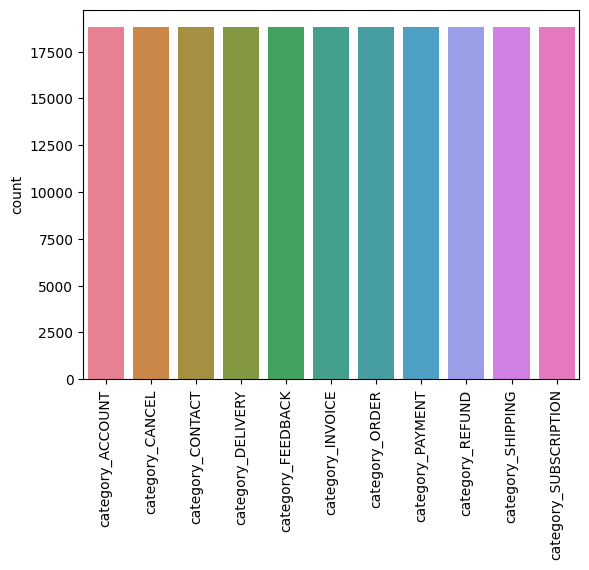

In [11]:
sns.countplot(y_train)
plt.xticks(rotation=90)
#g.set_xticklabels(rotation=30) 

In [12]:
# Explore noise
X['instruction'].apply(lambda x: nt.TextFrame(x).noise_scan())

0        {'text_noise': 10.416666666666668, 'text_lengt...
1        {'text_noise': 13.793103448275861, 'text_lengt...
2        {'text_noise': 10.638297872340425, 'text_lengt...
3        {'text_noise': 14.285714285714285, 'text_lengt...
4        {'text_noise': 13.333333333333334, 'text_lengt...
                               ...                        
26867    {'text_noise': 16.666666666666664, 'text_lengt...
26868    {'text_noise': 17.24137931034483, 'text_length...
26869    {'text_noise': 16.901408450704224, 'text_lengt...
26870    {'text_noise': 16.666666666666664, 'text_lengt...
26871    {'text_noise': 13.793103448275861, 'text_lengt...
Name: instruction, Length: 26872, dtype: object

In [13]:
# Explore noise
X['instruction_cleaned'].apply(lambda x: nt.TextFrame(x).noise_scan())

0        {'text_noise': 0, 'text_length': 38, 'noise_co...
1        {'text_noise': 0, 'text_length': 39, 'noise_co...
2        {'text_noise': 0, 'text_length': 41, 'noise_co...
3        {'text_noise': 0, 'text_length': 33, 'noise_co...
4        {'text_noise': 2.083333333333333, 'text_length...
                               ...                        
26867    {'text_noise': 0, 'text_length': 22, 'noise_co...
26868    {'text_noise': 6.666666666666667, 'text_length...
26869    {'text_noise': 1.9607843137254901, 'text_lengt...
26870    {'text_noise': 3.4482758620689653, 'text_lengt...
26871    {'text_noise': 2.941176470588235, 'text_length...
Name: instruction_cleaned, Length: 26872, dtype: object

In [14]:
dir(skmultilearn)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base',
 'problem_transform',
 'utils']

In [15]:
binary_rel_clf = BinaryRelevance(MultinomialNB())

In [16]:
binary_rel_clf.fit(X_train, y_train)

BinaryRelevance(classifier=MultinomialNB(), require_dense=[True, True])

In [17]:
# Predictions
br_predictions = binary_rel_clf.predict(X_test)
br_predictions

<8062x11 sparse matrix of type '<class 'numpy.int64'>'
	with 7927 stored elements in Compressed Sparse Column format>

In [18]:
br_predictions.toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [19]:
y_test

,category_ACCOUNT,category_CANCEL,category_CONTACT,category_DELIVERY,category_FEEDBACK,category_INVOICE,category_ORDER,category_PAYMENT,category_REFUND,category_SHIPPING,category_SUBSCRIPTION
21317,1,0,0,0,0,0,0,0,0,0,0
3901,0,1,0,0,0,0,0,0,0,0,0
7050,0,0,0,0,1,0,0,0,0,0,0
2785,0,0,0,0,0,0,0,0,0,1,0
1942,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
13752,0,0,0,1,0,0,0,0,0,0,0
10940,1,0,0,0,0,0,0,0,0,0,0
9244,0,0,1,0,0,0,0,0,0,0,0
15733,0,0,0,0,0,1,0,0,0,0,0


In [20]:
accuracy_score(y_test, br_predictions)

0.9805259240883155

In [21]:
# Incorrect prediction
# Lower the better
hamming_loss(y_test, br_predictions)

0.0018831329920389708

# Prediction

In [22]:
X.head()

,instruction,instruction_cleaned
0,question about cancelling order {{Order Number}},question cancelling order order number
1,i have a question about cancelling oorder {{Or...,question cancelling oorder order number
2,i need help cancelling puchase {{Order Number}},need help cancelling puchase order number
3,I need to cancel purchase {{Order Number}},need cancel purchase order number
4,"I cannot afford this order, cancel purchase {{...",cannot afford order cancel purchase order number


In [24]:
ex1 = X.loc[1000, 'instruction_cleaned']
ex1

'want help adding item order order number'

In [25]:
vec_sample = tfidf.transform([ex1])
vec_sample

<1x2758 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [26]:
binary_rel_clf.predict(vec_sample).toarray()

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [27]:
y.loc[1000, :]

category_ACCOUNT         0
category_CANCEL          0
category_CONTACT         0
category_DELIVERY        0
category_FEEDBACK        0
category_INVOICE         0
category_ORDER           1
category_PAYMENT         0
category_REFUND          0
category_SHIPPING        0
category_SUBSCRIPTION    0
Name: 1000, dtype: int64